# Task 5:

# food images classfication using neural network 

# importing the packages 

In [5]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import models,layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import random

# preparing the data

In [2]:
image_dir = Path(r'C:\Users\Abdallah\Documents\Task5\Data\food-101\food-101\images')

## extracting all the images paths

In [3]:
filepaths = list(image_dir.glob(r'**/*.jpg'))

## see how the images paths are structured

In [6]:
selected_files = random.choices(filepaths, k=3)

In [7]:
selected_files

[WindowsPath('C:/Users/Abdallah/Documents/Task5/Data/food-101/food-101/images/chocolate_cake/126340.jpg'),
 WindowsPath('C:/Users/Abdallah/Documents/Task5/Data/food-101/food-101/images/oysters/2763889.jpg'),
 WindowsPath('C:/Users/Abdallah/Documents/Task5/Data/food-101/food-101/images/guacamole/796559.jpg')]

### we see that the type of food is the first sub-directory of each .jpg image so for that let's try to extract it 

In [13]:
os.path.split(selected_files[0])

('C:\\Users\\Abdallah\\Documents\\Task5\\Data\\food-101\\food-101\\images\\chocolate_cake',
 '126340.jpg')

### it's split the path to two elements ## all the path except the last element of path and the last element of path 
### lets try to split two times to extract the folder of food type 

In [14]:
os.path.split(os.path.split(selected_files[0])[0])

('C:\\Users\\Abdallah\\Documents\\Task5\\Data\\food-101\\food-101\\images',
 'chocolate_cake')

### in the second element of tuple there is the food type of image  
### let's try to loop in all the image paths and extract the food type of each image

In [15]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [18]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)

## it's seems almost done !!! but now let's try to concat the labeles of food-type and image_paths using pandas 

In [19]:
labels = pd.Series(labels, name='Label')


In [20]:
images = pd.concat([filepaths, labels], axis=1)

In [105]:
images

,Filepath,Label
0,C:\Users\Abdallah\Documents\Task5\Data\food-10...,apple_pie
1,C:\Users\Abdallah\Documents\Task5\Data\food-10...,apple_pie
2,C:\Users\Abdallah\Documents\Task5\Data\food-10...,apple_pie
3,C:\Users\Abdallah\Documents\Task5\Data\food-10...,apple_pie
4,C:\Users\Abdallah\Documents\Task5\Data\food-10...,apple_pie
...,...,...
100995,C:\Users\Abdallah\Documents\Task5\Data\food-10...,waffles
100996,C:\Users\Abdallah\Documents\Task5\Data\food-10...,waffles
100997,C:\Users\Abdallah\Documents\Task5\Data\food-10...,waffles
100998,C:\Users\Abdallah\Documents\Task5\Data\food-10...,waffles


## now let's try to take only 100 image randomly from our previous example for each food-type 

In [21]:
category_samples = []

In [22]:
 for category in images['Label'].unique():
     category_slice = images.query("Label == @category")
     category_samples.append(category_slice.sample(100, random_state=1))
# here we concat the list of each food type to create only one dataframe     
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [138]:
image_df

,Filepath,Label
0,C:\Users\Abdallah\Documents\Task5\Data\food-10...,carrot_cake
1,C:\Users\Abdallah\Documents\Task5\Data\food-10...,gnocchi
2,C:\Users\Abdallah\Documents\Task5\Data\food-10...,bibimbap
3,C:\Users\Abdallah\Documents\Task5\Data\food-10...,gnocchi
4,C:\Users\Abdallah\Documents\Task5\Data\food-10...,poutine
...,...,...
111095,C:\Users\Abdallah\Documents\Task5\Data\food-10...,foie_gras
111096,C:\Users\Abdallah\Documents\Task5\Data\food-10...,scallops
111097,C:\Users\Abdallah\Documents\Task5\Data\food-10...,guacamole
111098,C:\Users\Abdallah\Documents\Task5\Data\food-10...,omelette


## that's it ,the data used , now because tensorflow accept only numerical values let's try to make the labels as integer from 0 to 100 instead of using the string labels and of curse the images will become matrice to be accepted

In [23]:
unique_labels = image_df['Label'].unique()
label_to_int = {label: i for i, label in enumerate(unique_labels)}
image_df['Label'] = image_df['Label'].map(label_to_int)


In [140]:
image_df

,Filepath,Label
0,C:\Users\Abdallah\Documents\Task5\Data\food-10...,0
1,C:\Users\Abdallah\Documents\Task5\Data\food-10...,1
2,C:\Users\Abdallah\Documents\Task5\Data\food-10...,2
3,C:\Users\Abdallah\Documents\Task5\Data\food-10...,1
4,C:\Users\Abdallah\Documents\Task5\Data\food-10...,3
...,...,...
111095,C:\Users\Abdallah\Documents\Task5\Data\food-10...,34
111096,C:\Users\Abdallah\Documents\Task5\Data\food-10...,10
111097,C:\Users\Abdallah\Documents\Task5\Data\food-10...,91
111098,C:\Users\Abdallah\Documents\Task5\Data\food-10...,12


## now before create the tensorflow dataset let's try to reduce the size of image from 255-255 to 32-32 pixels then normalize the pixel values to become between 0 and 1 

In [24]:
@tf.function
def load_and_preprocess_image(filepath, label):
    try:
        image = tf.io.read_file(filepath)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [32, 32])
        image = image / 255.0
    except tf.errors.InvalidArgumentError as e:
        print(f"Error processing file {filepath}: {e}")
        return None, label
    return image, label

# that it, this is the time to load the new images processed to the tensorflow dataset

In [25]:
image_paths = image_df['Filepath'].values
print(len(image_paths))
labels = image_df['Label'].values
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

# Apply the load and preprocess function
dataset = dataset.map(load_and_preprocess_image)
dataset = dataset.filter(lambda image, label: image is not None)

10100


## before we create the dataset let's try to add more features Shuffle, batch, and prefetch for optimal performance during training 

In [26]:
dataset = dataset.shuffle(buffer_size=len(image_df)).batch(32).prefetch(tf.data.AUTOTUNE)

# now let's try to split the dataset to train dataset 70% and test dataset 30%

In [42]:
# Assuming 'dataset' is your TensorFlow dataset
DATASET_SIZE = len(list(dataset))
# Calculate the size of training and testing datasets
train_size = int(0.7 * DATASET_SIZE)
test_size = DATASET_SIZE - train_size

# Split the dataset
train_df = dataset.take(train_size)
test_df = dataset.skip(train_size)

 now let's build our neural network that take as input image matrice 32-32 preprocessed with RGB coloring type and then we use three layeres CONV2D layer with 32 conventual filter to split the image to 32 diffrent channels with tail of 30 for each channel and then we apply CONV2D operation that's use in each channel the product of each filter in the channel with input matrice first 3-3 lines and columns and calculate the sum of result matrice and add to him the bias and apply to the result a relu fonction and put the result in the first line and column of the first channel matrice then it's move column by column and line by line in the input matrice to complete each channel matrice .
 then he move to MaxPooling2D layer that's takes the max value of each 2-2 elements in the input matrice to reduce the size of image from 30-30 to 15-15 .
 we do this layers two times to reduce the size of matrice and then we take the output of this layers and make them as input to the flatten layer that is responsible of transfer n-dimensionnel matrice to 1-dimensionnel matrice to give it with easy way as output to each neuron in dense layer with relu activation mode to elimnate the cases of negatives values which can reduce the calculations in the next layer softmax which is final layer responsible of classfication to 101 food type 

In [31]:
model=models.Sequential()

In [32]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # Define the input shape here
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(101, activation='softmax')
])

In [33]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 101)                 │           6,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,485 (501.89 KB)

 Trainable params: 128,485 (501.89 KB)

 Non-trainable params: 0 (0.00 B)

 now let's use adam algorithms for minimzing the loss fonction during the training and accuracy of each categoriy

In [34]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## now let's fit our model and train them for 30 times!!!!

In [37]:
history=model.fit(train_df,epochs=30,validation_data=test_df)

Epoch 1/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.3322 - loss: 2.6609 - val_accuracy: 0.3682 - val_loss: 2.5609
Epoch 2/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.3661 - loss: 2.5826 - val_accuracy: 0.4194 - val_loss: 2.3818
Epoch 3/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.3668 - loss: 2.5059 - val_accuracy: 0.4234 - val_loss: 2.3070
Epoch 4/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.4000 - loss: 2.3757 - val_accuracy: 0.4505 - val_loss: 2.1989
Epoch 5/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.4359 - loss: 2.2207 - val_accuracy: 0.4425 - val_loss: 2.2137
Epoch 6/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.4437 - loss: 2.1513 - val_accuracy: 0.4957 - val_loss: 2.0376
Epoch 7/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.4691 - loss: 2.0507 - val_accuracy: 0.5182 - val_loss: 1.9013
Epoch 8/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.4995 - loss: 1.9383 - 

# let's test it now with test dataset 

In [41]:
loss, accuracy = model.evaluate(test_df)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy* 100} %")

95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8952 - loss: 0.4136
Test Loss: 0.42224016785621643
Test Accuracy: 89.33289051055908 %


In [39]:
# Save your trained model
model.save('my_model.keras')

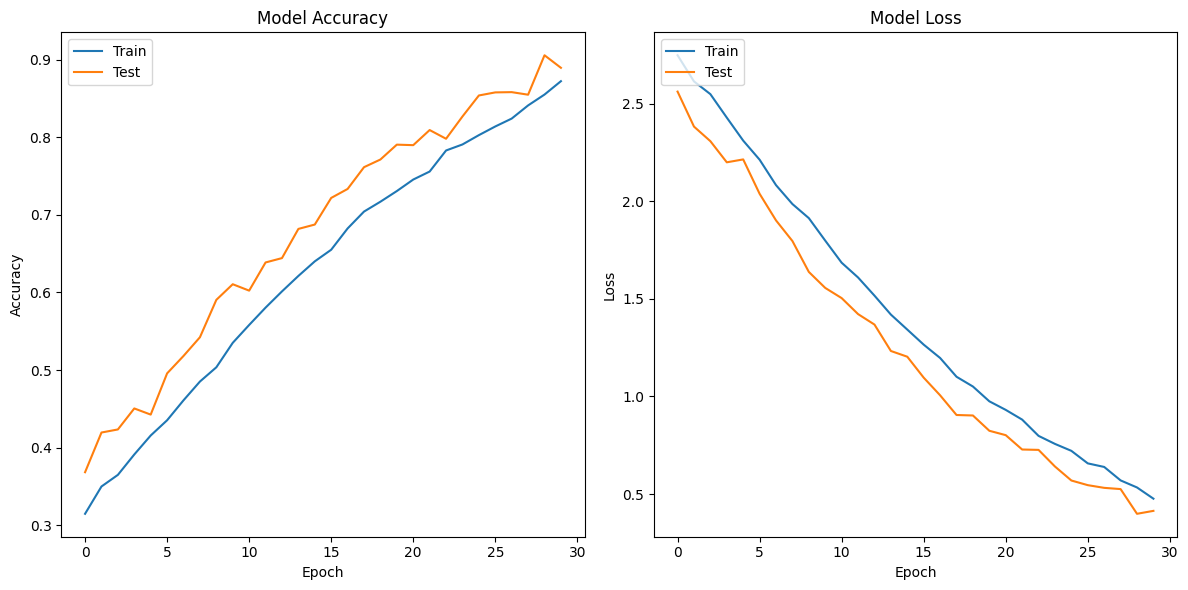

In [40]:
import matplotlib.pyplot as plt

# Ensure 'history' variable is defined and contains the history of the training process
# This assumes 'history' is already available from a previous model.fit execution

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()